In [2]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.model_selection import  GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [3]:
# transforms the prportion using logarithm in ordere to make predictions easier
def LogarithmProportion(row, column_name):
    p = row[column_name]
    return np.log(p/(1-p))

In [4]:

df = pd.read_csv(r".\data\merged_PAS_Crine_conf.csv")
df['Proportion'] = df.apply(lambda row: LogarithmProportion(row, "Proportion"), axis=1)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df

,Anti-social behaviour,Other crime,Burglary,Vehicle crime,Robbery,Other theft,Criminal damage and arson,Drugs,Shoplifting,Violence and sexual offences,Theft from the person,Public order,Bicycle theft,Possession of weapons,Proportion
Date,,,,,,,,,,,,,,,
2015-04-01,18327,685,5375,6569,1766,8457.0,5078.0,2591.0,3679.0,13536.0,3013.0,3302.0,1407.0,283.0,0.753772
2015-05-01,19630,706,5524,6993,1882,9245.0,5348.0,2658.0,3627.0,15058.0,3200.0,3504.0,1663.0,285.0,0.847298
2015-06-01,21392,734,5245,7261,1707,9383.0,5260.0,2780.0,3515.0,16562.0,2686.0,3720.0,1696.0,318.0,0.708185
2015-07-01,23311,757,5368,6630,1764,9821.0,5405.0,2922.0,3430.0,17432.0,2650.0,3793.0,1762.0,316.0,0.753772
2015-08-01,21826,683,5343,6454,1771,8927.0,4935.0,2961.0,3422.0,16176.0,2366.0,3561.0,1475.0,329.0,0.753772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,33833,964,5186,9096,2267,5663.0,4183.0,4360.0,2757.0,18697.0,2529.0,4200.0,1976.0,506.0,0.040005
2020-12-01,29358,768,4740,7686,2002,6247.0,4062.0,3572.0,2679.0,17563.0,3031.0,3848.0,1303.0,383.0,-0.080043
2021-01-01,33611,727,4261,7629,1436,4776.0,3613.0,3644.0,2086.0,16048.0,1595.0,3418.0,1048.0,345.0,-0.080043


In [6]:
def create_features(df):
    """
    Cretes time series features based on time series index.

    """
    df = df.copy()

    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    return df

df = create_features(df)

In [7]:
df.head()

,Anti-social behaviour,Other crime,Burglary,Vehicle crime,Robbery,Other theft,Criminal damage and arson,Drugs,Shoplifting,Violence and sexual offences,Theft from the person,Public order,Bicycle theft,Possession of weapons,Proportion,year,month,quarter
Date,,,,,,,,,,,,,,,,,,
2015-04-01,18327,685,5375,6569,1766,8457.0,5078.0,2591.0,3679.0,13536.0,3013.0,3302.0,1407.0,283.0,0.753772,2015,4,2
2015-05-01,19630,706,5524,6993,1882,9245.0,5348.0,2658.0,3627.0,15058.0,3200.0,3504.0,1663.0,285.0,0.847298,2015,5,2
2015-06-01,21392,734,5245,7261,1707,9383.0,5260.0,2780.0,3515.0,16562.0,2686.0,3720.0,1696.0,318.0,0.708185,2015,6,2
2015-07-01,23311,757,5368,6630,1764,9821.0,5405.0,2922.0,3430.0,17432.0,2650.0,3793.0,1762.0,316.0,0.753772,2015,7,3
2015-08-01,21826,683,5343,6454,1771,8927.0,4935.0,2961.0,3422.0,16176.0,2366.0,3561.0,1475.0,329.0,0.753772,2015,8,3


In [8]:

df.sort_index()

df['lag_1'] = df['Proportion'].shift(1)  # 1-month lag
df['lag_2'] = df['Proportion'].shift(2)  # 2- month lag
df['lag_3'] = df['Proportion'].shift(3)  # 1-month lag

df1 = df.iloc[:58].copy() # training_set
df2 = df.iloc[58:].copy()

df1.shape, df2.shape

((58, 21), (12, 21))

# K fold for XGboost

In [40]:

# Assuming df1 is your DataFrame with time series data

tss_1 = TimeSeriesSplit(n_splits=3, test_size=5)

# Define features and target
FEATURES = ['quarter', 'year', 'month','Criminal damage and arson', 'Drugs', 'Public order',
        'Violence and sexual offences', 'Shoplifting', 'Bicycle theft',
        'Anti-social behaviour', 'lag_1', 'lag_2', 'lag_3']
TARGET = "Proportion"

# Define XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=20)

# Define XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=20)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Make RMSE scorer for GridSearchCV (lower RMSE is better, so greater_is_better=False)
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define parameter grid for GridSearchCV
param_grid = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1 ,0.5, 1],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.5,0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'reg_lambda' : [0.01, 0.1, 0.5, 1.0,2,5,10.0]
    
}

# Perform GridSearchCV with TimeSeriesSplit cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tss_1, verbose=1, n_jobs=-1, scoring=rmse_scorer)

# Split data into features and target
X = df1[FEATURES]
y = df1[TARGET]

# Fit GridSearchCV on data
grid_search.fit(X, y)

# Access best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found by GridSearchCV:")
print(best_params)
print(f"Best score: {best_score}")

Fitting 3 folds for each of 4032 candidates, totalling 12096 fits
Best parameters found by GridSearchCV:
{'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 4, 'min_child_weight': 1, 'reg_lambda': 0.01, 'subsample': 0.5}
Best score: -0.15349145763430258


In [46]:
# some small hand udjusting to avoif overfitting

tss_2 = TimeSeriesSplit(n_splits=3, test_size=4)

df.sort_index()
# for now we don not include lags as we are missing two months

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss_2.split(df):

       train = df.iloc[train_idx]
       test = df.iloc[val_idx]

       FEATURES = ['quarter', 'year', 'month','Criminal damage and arson', 'Drugs', 'Public order',
              'Violence and sexual offences', 'Shoplifting', 'Bicycle theft',
              'Anti-social behaviour', 'lag_1', 'lag_2', 'lag_3']
       TARGET = "Proportion"

       X_train = train[FEATURES]
       y_train = train[TARGET]

       X_test = test[FEATURES]
       y_test = test[TARGET]

       xgb_model = XGBRegressor(colsample_bytree= 1, eta= 0.05, gamma=0, max_depth= 4, min_child_weight = 1, subsample =0.5, reg_lambda = 0.01, 
                                objective='reg:squarederror', random_state=42, n_estimators=25)
       
       xgb_model.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_test,y_test)], verbose=1)
       y_pred = xgb_model.predict(X_test)
       preds.append(y_pred)
       score = np.sqrt(mean_squared_error(y_test, y_pred))
       scores.append(score)

[0]	validation_0-rmse:0.28916	validation_1-rmse:0.54912
[1]	validation_0-rmse:0.27675	validation_1-rmse:0.52890
[2]	validation_0-rmse:0.26618	validation_1-rmse:0.50974


[3]	validation_0-rmse:0.25543	validation_1-rmse:0.49955
[4]	validation_0-rmse:0.24664	validation_1-rmse:0.49768
[5]	validation_0-rmse:0.23686	validation_1-rmse:0.48138
[6]	validation_0-rmse:0.22549	validation_1-rmse:0.46456
[7]	validation_0-rmse:0.21499	validation_1-rmse:0.45551
[8]	validation_0-rmse:0.20798	validation_1-rmse:0.44443
[9]	validation_0-rmse:0.20043	validation_1-rmse:0.42947
[10]	validation_0-rmse:0.19307	validation_1-rmse:0.42104
[11]	validation_0-rmse:0.18567	validation_1-rmse:0.41414
[12]	validation_0-rmse:0.17889	validation_1-rmse:0.40859
[13]	validation_0-rmse:0.17059	validation_1-rmse:0.40359
[14]	validation_0-rmse:0.16417	validation_1-rmse:0.39701
[15]	validation_0-rmse:0.15730	validation_1-rmse:0.39134
[16]	validation_0-rmse:0.15295	validation_1-rmse:0.38386
[17]	validation_0-rmse:0.14683	validation_1-rmse:0.37779
[18]	validation_0-rmse:0.14189	validation_1-rmse:0.36893
[19]	validation_0-rmse:0.13878	validation_1-rmse:0.36925
[20]	validation_0-rmse:0.13325	validat

In [47]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'fold scores{scores}')

Score across folds 0.3823
fold scores[0.34285560183151215, 0.41380870925815544, 0.3902138808043911]


In [51]:
train = df.iloc[:65]
test = df.iloc[65:]

FEATURES = ['quarter', 'year', 'month','Criminal damage and arson', 'Drugs', 'Public order',
        'Violence and sexual offences', 'Shoplifting', 'Bicycle theft',
        'Anti-social behaviour', 'lag_1', 'lag_2', 'lag_3']
TARGET = "Proportion"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

xgb_model = XGBRegressor(colsample_bytree= 0.8, eta= 0.05, gamma=0, max_depth= 4, min_child_weight = 1, subsample =0.5, reg_lambda = 0.01, 
                        objective='reg:squarederror', random_state=42, n_estimators=25)

xgb_model.fit(X_train, y_train, eval_set=[(X_train,y_train), (X_test,y_test)], verbose=1)
y_pred = xgb_model.predict(X_test)

score = np.sqrt(mean_squared_error(y_test, y_pred))

[0]	validation_0-rmse:0.33641	validation_1-rmse:0.69274
[1]	validation_0-rmse:0.32163	validation_1-rmse:0.67594
[2]	validation_0-rmse:0.30994	validation_1-rmse:0.64920
[3]	validation_0-rmse:0.29711	validation_1-rmse:0.64042
[4]	validation_0-rmse:0.28325	validation_1-rmse:0.61027
[5]	validation_0-rmse:0.27068	validation_1-rmse:0.59337
[6]	validation_0-rmse:0.25790	validation_1-rmse:0.58275
[7]	validation_0-rmse:0.24601	validation_1-rmse:0.56686
[8]	validation_0-rmse:0.23522	validation_1-rmse:0.55412
[9]	validation_0-rmse:0.22339	validation_1-rmse:0.54753
[10]	validation_0-rmse:0.21361	validation_1-rmse:0.53243
[11]	validation_0-rmse:0.20422	validation_1-rmse:0.51932
[12]	validation_0-rmse:0.19502	validation_1-rmse:0.49847
[13]	validation_0-rmse:0.18687	validation_1-rmse:0.49782
[14]	validation_0-rmse:0.17880	validation_1-rmse:0.48768
[15]	validation_0-rmse:0.17173	validation_1-rmse:0.48162
[16]	validation_0-rmse:0.16543	validation_1-rmse:0.47835
[17]	validation_0-rmse:0.15842	validation

# Plotting the prediction

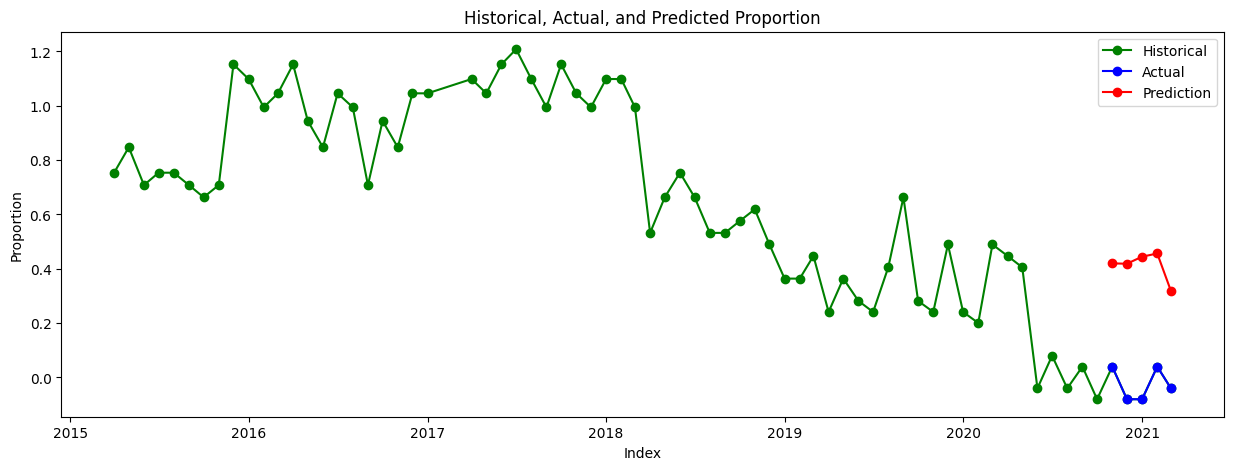

In [54]:
# Concatenate train and test data
historical_data = pd.concat([train, test])

# Copy the test data and add predictions
test_simple = test.copy()
test_simple['prediction'] = y_pred

# Plot actual data and predictions
plt.figure(figsize=(15, 5))
plt.plot(historical_data.index, historical_data['Proportion'], marker='o', linestyle='-', color='g', label='Historical')
plt.plot(test_simple.index, test_simple['Proportion'], marker='o', linestyle='-', color='b', label='Actual')
plt.plot(test_simple.index, test_simple['prediction'], marker='o', linestyle='-', color='r', label='Prediction')

# Set labels and title
plt.xlabel('Index')  # You can customize this to your needs (e.g., date/time if applicable)
plt.ylabel('Proportion')
plt.title('Historical, Actual, and Predicted Proportion of Confidence')
plt.legend()

plt.show()

# Feature importance


In [55]:
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
print(feature_importance_df) 

                         Feature  Importance
10                         lag_1    0.322974
12                         lag_3    0.136495
1                           year    0.133302
11                         lag_2    0.090243
4                          Drugs    0.079847
9          Anti-social behaviour    0.049243
8                  Bicycle theft    0.046637
3      Criminal damage and arson    0.042338
5                   Public order    0.041194
7                    Shoplifting    0.021902
0                        quarter    0.014457
6   Violence and sexual offences    0.011603
2                          month    0.009765
